In [20]:
# General imports
import numpy as np
import qiskit
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import DensityMatrix, partial_trace
# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [21]:
# [Reference]: https://docs.quantum.ibm.com/guides/build-noise-models
# https://docs.quantum.ibm.com/guides/simulate-with-qiskit-aer

from qiskit_aer import AerSimulator

from qiskit_aer.primitives import SamplerV2 as Sampler
#from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit.primitives import StatevectorSampler
# sampler = StatevectorSampler()
sampler = Sampler()


from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import (NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# YOUR_API_TOKEN = "a44932650c6324c729fbd156e2808cff2dc96cc78fdaf3058a5e3583edfadad4acf73471140788f0efa7ed71a98f1e13069af52fe115e4e0e2bb868ab0be5d70"
# QiskitRuntimeService.save_account(channel="ibm_quantum", token= YOUR_API_TOKEN, overwrite = True)
# service = QiskitRuntimeService()
# backend = service.backend("ibm_brisbane")
# noise_model = NoiseModel.from_backend(backend)

In [22]:
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix, kron
from numpy import trace

Total number of parameters:  33


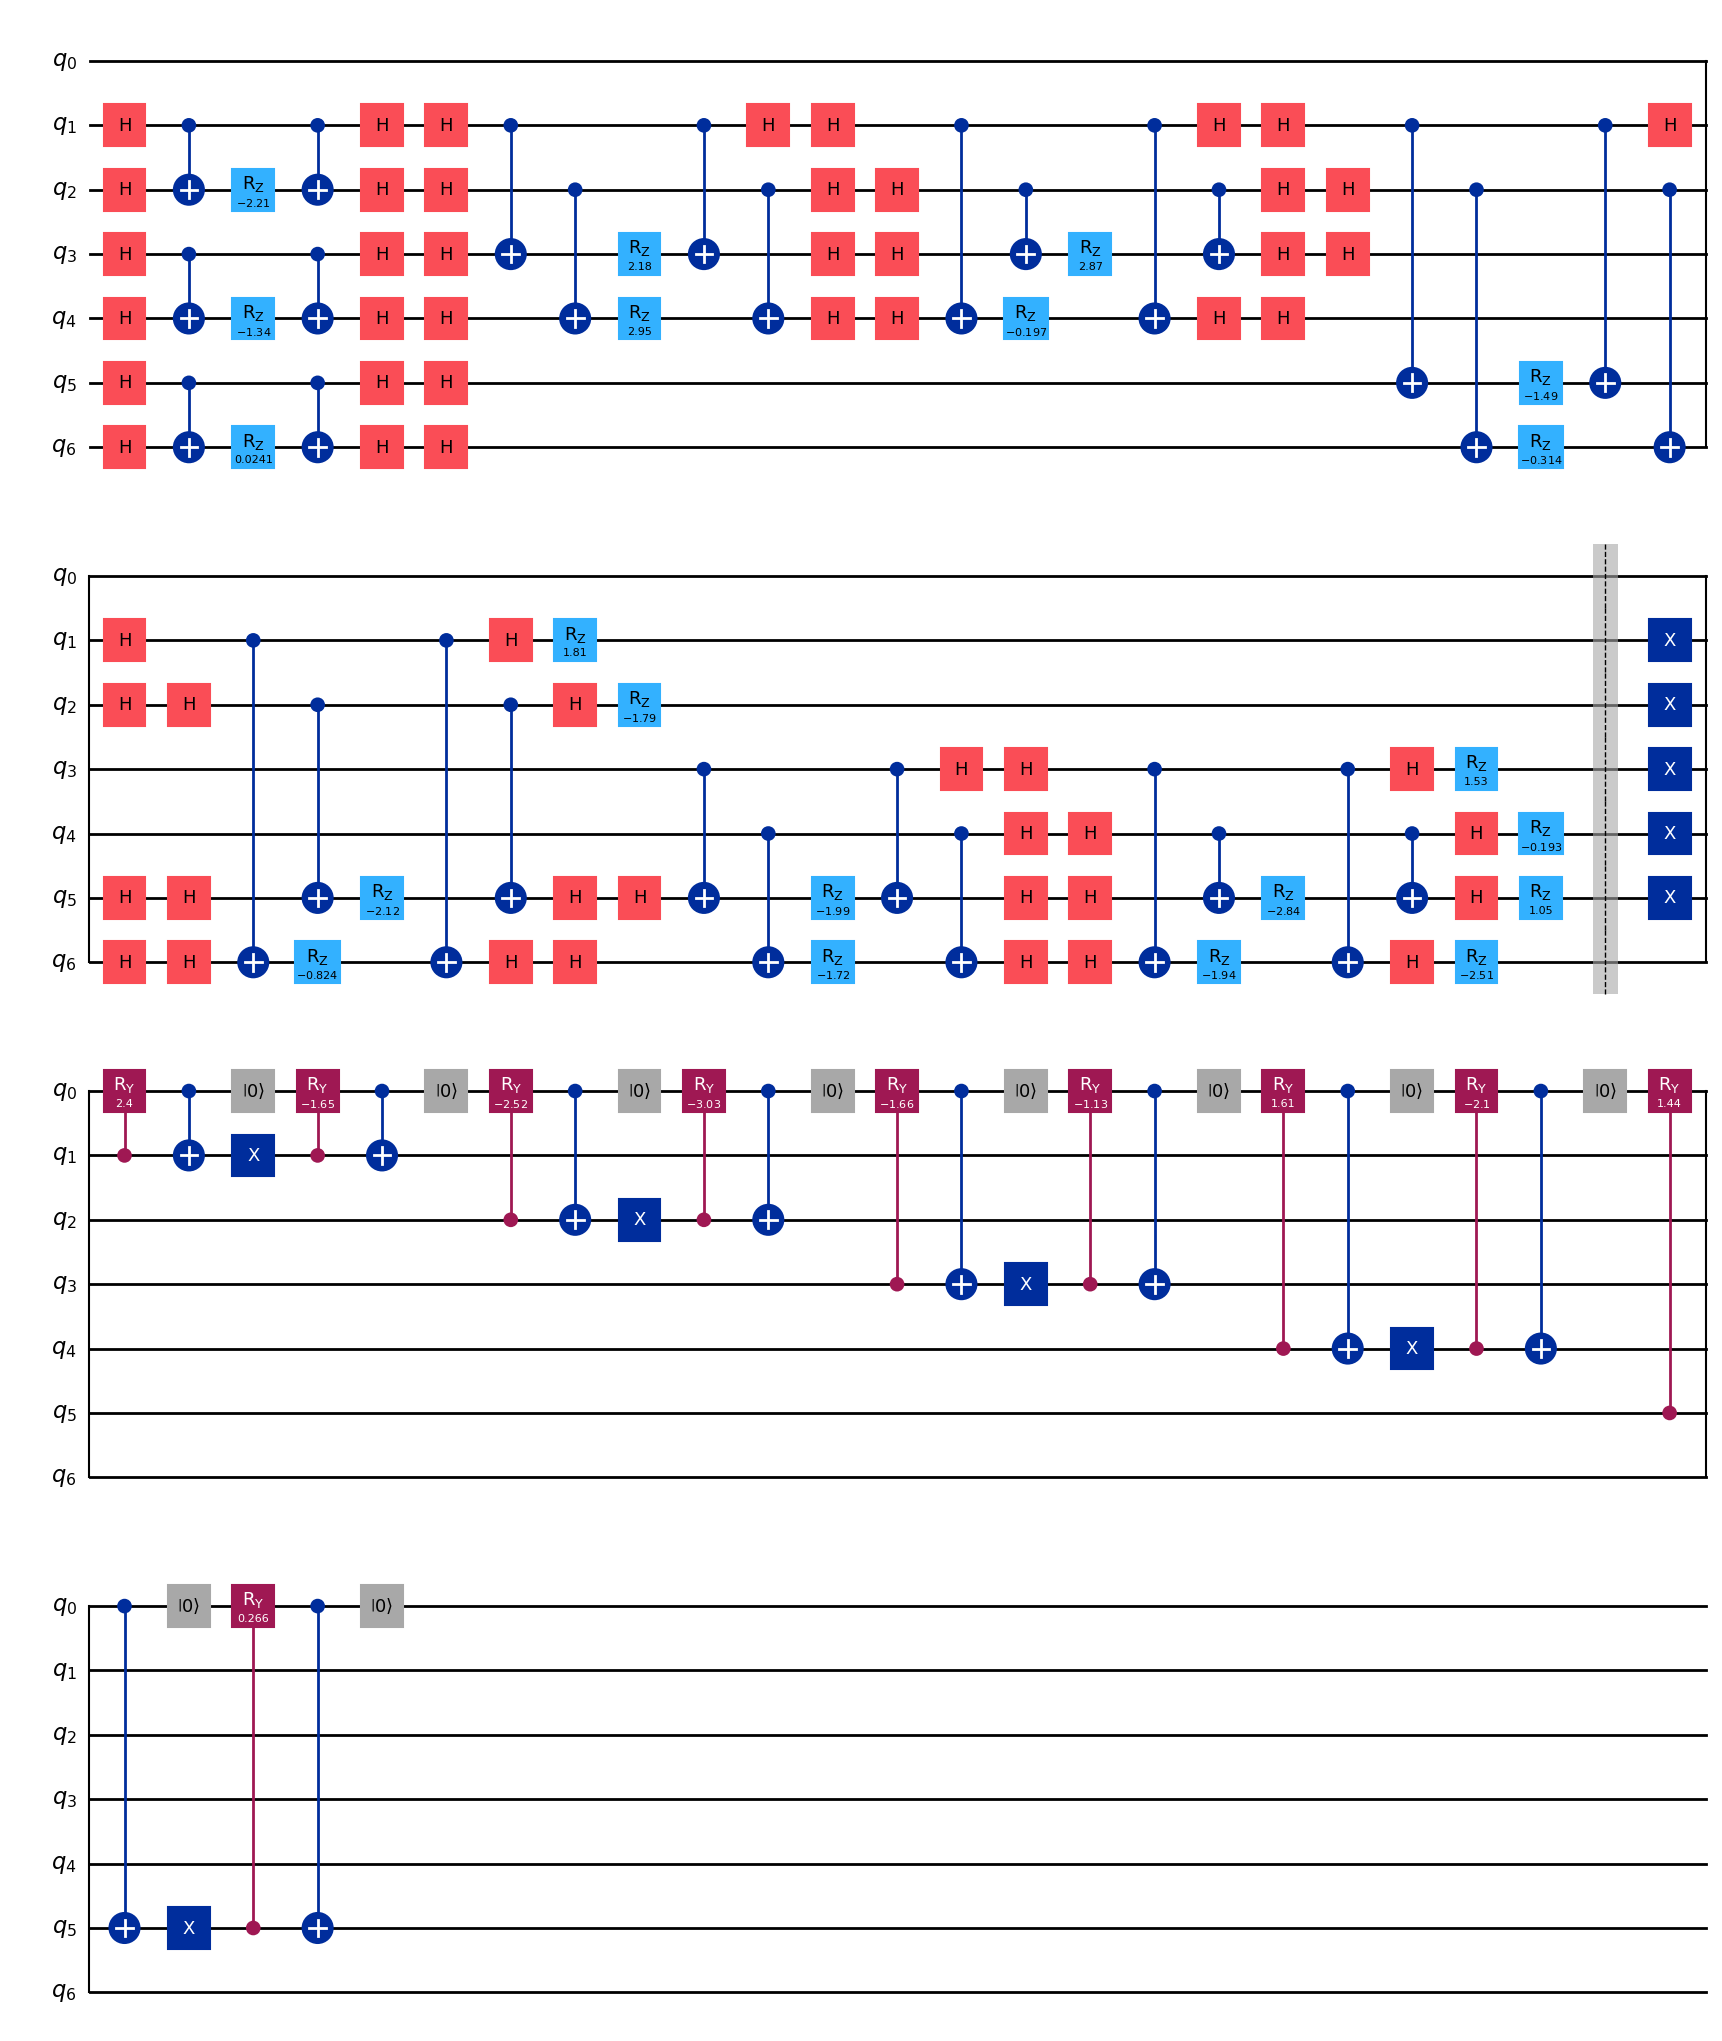

In [ ]:
# VQA circuit.
from qiskit import QuantumCircuit

# Pauli matrices and identity (sparse format)
I = csr_matrix([[1, 0], [0, 1]], dtype=complex)
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=complex)
sigma_y = csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=complex)

# The variational circuit is just the trotter circuit for the TFIM.
n_qubits = 5

# For parallelization of the circuit we will group the qubits.
def divide_pairs(pairs):
    sets = []  # List to hold the sets of pairs
    for pair in pairs:
        added = False
        for s in sets:
            # Check if the pair conflicts with any existing set
            if all(len(set(pair).intersection(set(existing_pair))) == 0 for existing_pair in s):
                s.append(pair)
                added = True
                break
        if not added:
            # If no compatible set found, create a new set
            sets.append([pair])
    return sets

qubits_grouped = divide_pairs([(i,j) for i in range(1, n_qubits +1 ) for j in range(i+1, n_qubits + 1)])

def variational_circuit(angles_lst, number_of_layers):  

    anstaz_circuit = QuantumCircuit(n_qubits + 1)

    for l in range(number_of_layers):
        angle_count = 0
        for qubit_set in qubits_grouped:
            for qubit in qubit_set:
                anstaz_circuit.h(qubit[0])
                anstaz_circuit.h(qubit[1])
                anstaz_circuit.cx(qubit[0], qubit[1])
                anstaz_circuit.rz(angles_lst[l][angle_count], qubit[1])
                angle_count += 1
                anstaz_circuit.cx(qubit[0], qubit[1])
                anstaz_circuit.h(qubit[0])
                anstaz_circuit.h(qubit[1])

        for q in range(n_qubits):
            anstaz_circuit.rz(angles_lst[l][angle_count], q + 1)
            angle_count += 1

        anstaz_circuit.barrier()
        for q in range(1, n_qubits):
            anstaz_circuit.x(q)
            anstaz_circuit.cry(angles_lst[l][angle_count], q, 0)
            angle_count += 1
            anstaz_circuit.cx(0,q)
            anstaz_circuit.x(q)
            anstaz_circuit.reset(0)       

            anstaz_circuit.cry(angles_lst[l][angle_count], q, 0)
            angle_count += 1
            anstaz_circuit.cx(0,q)
            anstaz_circuit.reset(0)                 

    return anstaz_circuit   

import math
number_of_parameters_per_layer = math.comb(n_qubits, 2) + 3 * n_qubits

number_of_layer = 1
parameters_lst = [[np.random.uniform(-np.pi, np.pi) for i in range(number_of_parameters_per_layer)] for j in range(number_of_layer)]
print("Total number of parameters: ", len(np.array(parameters_lst).flatten()))
variational_circuit(parameters_lst, number_of_layer).draw("mpl", scale = 1)  
# Transpile the quantum circuit to the basis gates.
# from qiskit import transpile
# vqa_transpiled = transpile(variational_circuit(parameters_lst, number_of_layer), basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)
# vqa_transpiled.draw("mpl", scale = 1)

In [24]:
L = n_qubits
from qiskit_aer.noise import (
    NoiseModel,QuantumError,ReadoutError,depolarizing_error,pauli_error,thermal_relaxation_error,
)
"""
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05
 
# QuantumError objects
error_reset = pauli_error([("X", p_reset), ("I", 1 - p_reset)])
error_meas = pauli_error([("X",p_meas), ("I", 1 - p_meas)])
error_gate1 = pauli_error([("X",p_gate1), ("I", 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
 
# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

noise_model = noise_bit_flip
 
# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ["u1", "u2", "u3"])
"""

# T1 and T2 values for qubits 0-3
T1s = np.random.normal(150e3, 10e3, L+1)  # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(500e3, 10e3, L+1)  # Sampled from normal distribution mean 50 microsec
 
# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(L+1)])
 
# Instruction times (in nanoseconds)
time_u1 = 0  # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100  # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000  # 1 microsecond
 
# QuantumError objects
errors_reset = [
    thermal_relaxation_error(t1, t2, time_reset) for t1, t2 in zip(T1s, T2s)
]
errors_measure = [
    thermal_relaxation_error(t1, t2, time_measure) for t1, t2 in zip(T1s, T2s)
]
errors_u1 = [
    thermal_relaxation_error(t1, t2, time_u1) for t1, t2 in zip(T1s, T2s)
]
errors_u2 = [
    thermal_relaxation_error(t1, t2, time_u2) for t1, t2 in zip(T1s, T2s)
]
errors_u3 = [
    thermal_relaxation_error(t1, t2, time_u3) for t1, t2 in zip(T1s, T2s)
]
errors_cx = [
    [
        thermal_relaxation_error(t1a, t2a, time_cx).expand(
            thermal_relaxation_error(t1b, t2b, time_cx)
        )
        for t1a, t2a in zip(T1s, T2s)
    ]
    for t1b, t2b in zip(T1s, T2s)
]
 
# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(L+1):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(L+1):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
 
noise_model = noise_thermal
print(noise_model)
from qiskit import transpile
def return_density_matrix(quantum_circuit, noise_model=None):

    quantum_circuit.save_density_matrix()  # Save the density matrix

    # Step 2: Simulate the circuit
    simulator = AerSimulator(noise_model=noise_thermal)  # Aer simulator supports reset gates
    #simulator = AerSimulator()  # Aer simulator supports reset gates
    quantum_circuit = transpile(quantum_circuit, simulator)
    result = simulator.run(quantum_circuit).result()
    # Step 3: Extract the density matrix
    rho_full = DensityMatrix(result.data()["density_matrix"])

    # Step 4: Compute the reduced density matrix for the second qubit
    rho_1 = partial_trace(rho_full, [0])  # Trace out qubit 0
    rho_1_matrix = rho_1.data

    return rho_1_matrix

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['reset', 'cx', 'u3', 'u2', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('reset', (5,)), ('reset', (6,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('measure', (5,)), ('measure', (6,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u2', (4,)), ('u2', (5,)), ('u2', (6,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('u3', (4,)), ('u3', (5,)), ('u3', (6,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (0, 4)), ('cx', (0, 5)), ('cx', (0, 6)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (1, 4)), ('cx', (1, 5)), ('cx', (1, 6)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (2, 4)), ('cx', (2, 5)), ('cx', (2, 6)), ('cx', (3, 0)), (

In [32]:
# Pauli matrices and identity (sparse format)
I2 = csr_matrix([[1, 0], [0, 1]], dtype=complex)
sigma_x = csr_matrix([[0, 1], [1, 0]], dtype=complex)
sigma_y = csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
sigma_z = csr_matrix([[1, 0], [0, -1]], dtype=complex)

n = n_qubits
# Constants
J_total = 1
Delta = 0.5
gamma = 0.3
gamma_e = gamma
gamma_d = gamma

def build_hamiltonian(n):
    """Construct the Hamiltonian for the infinite-ranged Ising model."""
    H = csr_matrix((2**n, 2**n), dtype=complex)

    J_0 = J_total / (n-1)
    # Infinite ranged XX term
    for i in range(n-1):
        for j in range(i+1, n):
            X_ops = [I2] * n
            X_ops[i] = sigma_x
            X_ops[j] = sigma_x
            X_term = X_ops[0]
            for op in X_ops[1:]:
                X_term = kron(X_term, op)

            H += J_0 * X_term

    # Z field term
    for i in range(n):
        Z_ops = [I2] * n
        Z_ops[i] = sigma_z
        Z_term = Z_ops[0]
        for op in Z_ops[1:]:
            Z_term = kron(Z_term, op)

        H -= Delta * Z_term

    return H

def lindblad_equation(rho):

    H = build_hamiltonian(n)
    
    # Hamiltonian contribution
    H_comm = -1j * (H @ rho - rho @ H)

    lindblad_diss_term = csr_matrix((2**n, 2**n), dtype=complex)
    for i in range(n):
        # sigma+ operator
        sigma_plus_i = [I2] * n
        sigma_plus_i[i] = (sigma_x + 1j*sigma_y) / 2
        sigma_plus_i_op = sigma_plus_i[0]
        for op in sigma_plus_i[1:]:
            sigma_plus_i_op = kron(sigma_plus_i_op, op)

        # sigma- operator
        sigma_minus_i_op = sigma_plus_i_op.conj().T

        # sigma_z operator
        sigma_z_i = [I2] * n
        sigma_z_i[i] = sigma_z
        sigma_z_i_op = sigma_z_i[0]
        for op in sigma_z_i[1:]:
            sigma_z_i_op = kron(sigma_z_i_op, op)

        lindblad_diss_term += gamma_e/2 * (sigma_plus_i_op @ sigma_minus_i_op @ rho + rho @ sigma_plus_i_op @ sigma_minus_i_op - 2 * sigma_minus_i_op @ rho @ sigma_plus_i_op)
        lindblad_diss_term += gamma_d/4 * (rho - sigma_z_i_op @ rho @ sigma_z_i_op)

    return H_comm - lindblad_diss_term

# def cost_function(rho, L_vec):
#     """Compute the cost function Tr[(L(rho))^2]."""
#     rho_vec = rho.flatten(order="F")  # Vectorize rho
#     L_rho_vec = L_vec @ rho_vec  # Apply Liouvillian
#     return np.linalg.norm(L_rho_vec)**2  # Compute squared norm

# Cost function
def cost_function(rho):
    L_rho = lindblad_equation(rho)
    return np.real(np.trace(L_rho.conj().T @ L_rho))    

In [33]:
import copy

def update_angles(current_angles_lst, number_of_layers, number_of_parameters_per_layer, learning_rate):
    """
    Perform parameter-shift updates on angles for a VQA circuit.

    Parameters:
        current_angles_lst (array): Current angles for each layer (shape: [number_of_layers, number_of_parameters_per_layer]).
        number_of_layers (int): Number of layers in the VQA circuit.
        number_of_parameters_per_layer (int): Number of parameters per layer.
        learning_rate (float): Learning rate for gradient descent.

    Returns:
        updated_angles (array): Updated angles after applying parameter-shift rule.
    """
    # Initialize updated angles as a copy of the current angles
    updated_angles = np.copy(current_angles_lst)
    
    # Iterate over each layer and each parameter
    for i in range(number_of_layers):
        for j in range(number_of_parameters_per_layer):
            # Create shifted angle sets for parameter (i, j)
            angles_plus = copy.deepcopy(current_angles_lst)
            angles_minus = copy.deepcopy(current_angles_lst)
            
            # Shift the specific parameter
            angles_plus[i][j] += np.pi / 2
            angles_minus[i][j] -= np.pi / 2
            
            # Compute the cost for shifted parameters
            cost_plus = cost_function(return_density_matrix(variational_circuit(angles_plus, number_of_layers)))
            cost_minus = cost_function(return_density_matrix(variational_circuit(angles_minus, number_of_layers)))
            
            # Compute the gradient for this parameter
            gradient = (cost_plus - cost_minus) / 2
            
            # Debugging: Print intermediate gradient values
            #print(f"Layer {i}, Parameter {j}, Gradient: {gradient}")
            
            # Update the parameter using gradient descent
            updated_angles[i][j] -= learning_rate * gradient
    
    return updated_angles

In [34]:
from qiskit import transpile

# Parameters
initial_learning_rate = 1
decay_rate = 1
number_of_layers = 2
max_iterations = 20
tolerance_for_convergence = 1e-4

number_of_parameters_per_layer = math.comb(n_qubits, 2) + 3*n_qubits

# We will initialize the initial angles as the trotter angles.
trotter_step = 0.1
J = 1/(n_qubits-1)
Delta = Delta
initial_angles_lst = [[J*trotter_step*2 for _ in range(math.comb(n_qubits, 2))] +
[-Delta*trotter_step*2 for _ in range(n_qubits)] + [np.sqrt(trotter_step*gamma) for _ in range(2*n_qubits)] for _ in range(number_of_layers)]

# initial_angles_lst = [[np.random.uniform(-np.pi, np.pi) for _ in range(number_of_parameters_per_layer)] for _ in range(number_of_layers)]

import copy
angles_lst = copy.deepcopy(initial_angles_lst)
best_angles_lst = copy.deepcopy(initial_angles_lst)

# Initialize optimization variables
number_of_iteration = 0
best_cost = float("inf")
best_iteration = 0
cost_function_values_lst = []
rho_lst = []

# Optimization loop
while number_of_iteration < max_iterations:
    #print("Current angles: ", angles_lst)
    # Generate variational circuit and compute cost
    vqa_circuit = variational_circuit(angles_lst, number_of_layers)
    rho = return_density_matrix(vqa_circuit)
    rho_lst.append(rho)
    cost_value = cost_function(rho)

    # Record and display the cost
    cost_function_values_lst.append(cost_value)
    print(f"Iteration {number_of_iteration}: Cost value = {cost_value:.6f}")

    # Update best solution
    if cost_value < best_cost:
        best_cost = cost_value
        best_angles_lst = angles_lst.copy()
        best_iteration = number_of_iteration

    # Check for convergence
    if number_of_iteration > 0 and abs(cost_function_values_lst[-1] - cost_function_values_lst[-2]) < tolerance_for_convergence:
        print("Optimization has converged.")
        print(f"Best cost value: {best_cost:.6f}")
        print("Best angles:", best_angles_lst)
        break

    # Adjust learning rate
    learning_rate = initial_learning_rate / (1 + decay_rate * number_of_iteration)

    # Update angles using the parameter-shift rule
    angles_lst = update_angles(angles_lst, number_of_layers, number_of_parameters_per_layer, learning_rate)

    # Increment iteration counter
    number_of_iteration += 1

# Post-optimization summary
if number_of_iteration == max_iterations:
    print("The optimization did not converge within the maximum iterations.")
print(f"Best cost value: {best_cost:.6f}")
print("Best angles:", best_angles_lst)

Iteration 0: Cost value = 3.179835
Iteration 1: Cost value = 3.282230
Iteration 2: Cost value = 3.073198
Iteration 3: Cost value = 1.812732
Iteration 4: Cost value = 1.543527
Iteration 5: Cost value = 1.391238
Iteration 6: Cost value = 1.292181
Iteration 7: Cost value = 1.221975
Iteration 8: Cost value = 1.169205
Iteration 9: Cost value = 1.127808
Iteration 10: Cost value = 1.094267
Iteration 11: Cost value = 1.066394
Iteration 12: Cost value = 1.042758
Iteration 13: Cost value = 1.022383
Iteration 14: Cost value = 1.004576
Iteration 15: Cost value = 0.988834
Iteration 16: Cost value = 0.974780
Iteration 17: Cost value = 0.962128
Iteration 18: Cost value = 0.950653
Iteration 19: Cost value = 0.940180
The optimization did not converge within the maximum iterations.
Best cost value: 0.940180
Best angles: [[ 0.12823983  0.12603949  0.16580022  0.12891049  0.12678039  0.12800719
   0.12700897  0.12895745  0.16703514  0.167734    0.12651787  0.1277121
   0.16856735  0.16703256  0.12612527 -

In [35]:
# Find index of minimum cost
min_cost_index = cost_function_values_lst.index(min(cost_function_values_lst))

# Get corresponding density matrix 
best_rho = rho_lst[min_cost_index]

print(f"Best cost value found at iteration {min_cost_index}: {min(cost_function_values_lst)}")

Best cost value found at iteration 19: 0.9401800445446631


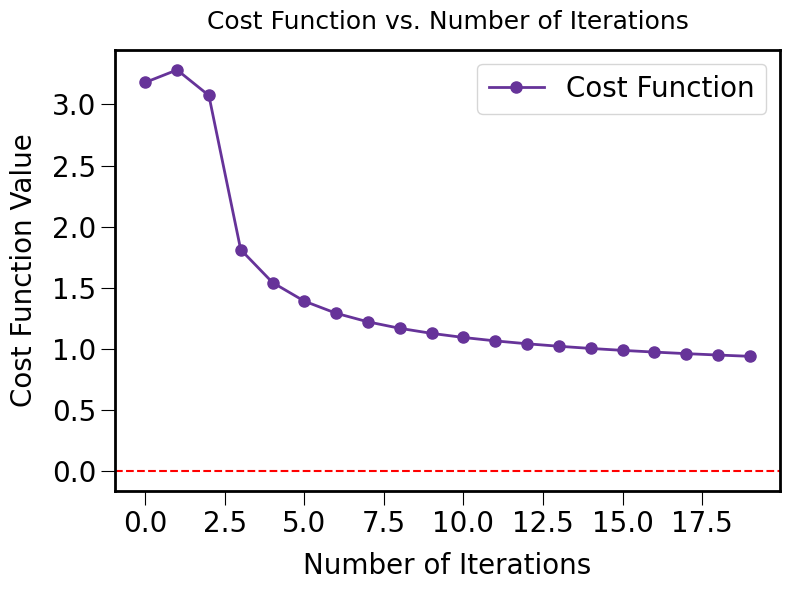

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(range(len(cost_function_values_lst)), cost_function_values_lst, marker="o", linestyle='-', color="rebeccapurple", linewidth=2, markersize=8, label="Cost Function")
plt.xlabel("Number of Iterations", fontsize=20, labelpad=10)
plt.ylabel("Cost Function Value", fontsize=20, labelpad=10)
plt.title("Cost Function vs. Number of Iterations", fontsize=18, pad=15)
#plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(y=0, color="r", linestyle="--")
# Get current axis
ax = plt.gca()
# Make axis lines thicker
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
# Make ticks longer
ax.tick_params(axis='both', which='major', length=10)
plt.tight_layout()
#plt.axhline(y=0.8, color="r", linestyle="--")
plt.show()

In [37]:
def FM_order(rho):
    # Initialize the spin correlation matrix
    spin_matrix = csr_matrix((rho.shape[0], rho.shape[0]), dtype=complex)
    
    for i in range(n):
        for j in range(n):
            # Create sigma_x operator for qubit i
            sigma_x_ij = [I2] * n
            sigma_x_ij[i] = sigma_x            
            # Create sigma_x operator for qubit j
            sigma_x_ij[j] = sigma_x
            sigma_x_ij_op = sigma_x_ij[0]
            for op in sigma_x_ij[1:]:
                sigma_x_ij_op = kron(sigma_x_ij_op, op)
                
            spin_matrix += sigma_x_ij_op

    # Calculate M_F using the trace formula
    mf = np.trace(spin_matrix @ rho) / n**2
    return mf.real  # Return the real part (expectation values are real)

In [38]:
rho = rho_lst[min_cost_index]
FM_order(rho)

-0.062309476881361466